In [1]:
%load_ext autoreload 
%autoreload 2

import matplotlib.pyplot as plt
import  aslid
import target



###################################
# TensorFlow wizardry
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################



basepath='/home/facundo/datasets/pose/aslid/'
localization_grid_shape=(12,16)
localization_target=target.LocalizationTargetGrid(localization_grid_shape,aslid.body_parts)
train_iterator=aslid.ASLIDIterator(basepath,'train',localization_target,batch_size=64,resize=(240,352))
test_iterator=aslid.ASLIDIterator(basepath,'train',localization_target,batch_size=64)

input_shape=train_iterator.image_shape
classes = localization_target.dims()
print("Input shape %s" % str(input_shape))
print("Classes %s" % str(classes))

/home/facundo/.python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Input shape (240, 352, 3)
Classes 1344


(32, 240, 352, 3)


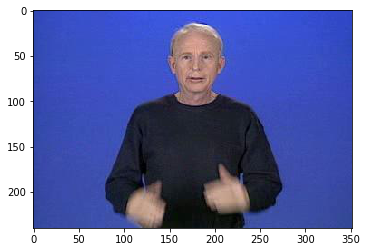

[  2.21685725e-50   2.18838772e-45   7.94724002e-41 ...,   1.29854188e-15
   2.64212199e-19   1.97767666e-23]


In [2]:
xb,yb=train_iterator.next()
plt.imshow(xb[0,:,:,:])
print(xb.shape)
plt.show()
print(yb[0,:])


In [3]:
import models
import resnext

model=resnext.residual_network(input_shape,classes)



#model=models.resnext(input_shape,classes)
#model=models.simple_conv(input_shape,classes)
#model=models.conv_mask(input_shape,classes)
model.summary()

optimizer='rmsprop'
#optimizer= optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer,
              loss=localization_target.loss,
              metrics=[localization_target.metric])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 352, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 119, 175, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 119, 175, 32) 4128        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 119, 175, 32) 4128        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (

In [ ]:
from keras import optimizers


history=model.fit_generator(train_iterator,steps_per_epoch=100, epochs=5)



Epoch 1/5
 33/100 [========>.....................] - ETA: 52s - loss: 3.0044 - metric: 0.5610

In [5]:
print(model.metrics_names)

train_iterator.reset()
test_iterator.reset()
print("train loss, accuracy", model.evaluate_generator(train_iterator,steps=train_iterator.get_batches()))
print("test loss, accuracy", model.evaluate_generator(test_iterator,steps=test_iterator.get_batches()))

['loss', 'metric']
train loss, accuracy [3.2506988374872359, 0.36445306724743542]
test loss, accuracy [3.2506989853596715, 0.36445306452811133]


### Check that predictions on training set are ok

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
import numpy as np
import matplotlib.patches as patches
import utils
import matplotlib.colors

def hues_colormap(max_n=8,saturation=1.0,luminance=1.0):
    colormap = np.array([(x*1.0/max_n, saturation, luminance) for x in range(max_n)])
    
    colormap_rgb = np.zeros((max_n,3))
    for i in range(max_n):
        colormap_rgb[i,:]=matplotlib.colors.hsv_to_rgb(colormap[i,:])
    return colormap_rgb

def body_parts_colors(body_parts,saturation=0.5,luminance=1):
    n=len(body_parts)
    colormap=hues_colormap(max_n=n,saturation=saturation,luminance=luminance)
    colors={}
    n_colormap=colormap.shape[0]
    for i in range(n):
        body_part=body_parts[i]
        index = i % n_colormap
        colors[body_part]=colormap[i,:]
    return colors
        
def draw_coordinates(image_index,body_parts_coordinates_true,body_parts_coordinates_predicted=None,ax=plt.gca()):
    #image_index=0
    body_parts=list(body_parts_coordinates_true.keys())
    body_parts_colors_true=body_parts_colors(body_parts,saturation=1,luminance=1)
    body_parts_colors_predicted=body_parts_colors(body_parts,saturation=0.5,luminance=0.6)
    for bp in body_parts:
            true_coordinates=body_parts_coordinates_true[bp]
            draw_square(true_coordinates[image_index,:],color=body_parts_colors_true[bp],ax=ax)
            if (body_parts_coordinates_predicted):
                coordinates=body_parts_coordinates_predicted[bp]
                draw_square(coordinates[image_index,:],color=body_parts_colors_predicted[bp],ax=ax)
    
def draw_square(position,size=15,color='#eeefff',center=False,ax=plt.gca()):
    
    size_x,size_y=(size,size)
    if center:
        position_reversed=(position[1]-size_y/2,position[0]-size_x/2)
    else:
        position_reversed=(position[1],position[0])
    rectangle=patches.Rectangle(position_reversed, size_x,size_y, fill=True,color=color)
    ax.add_patch(rectangle)

#iterator.image_position_to_grid_position(np.array([12,16]),np.array([240,316]),np.array([239,315]))

xb,yb=iterator.next()


batch_x,batch_y=train_iterator.next()
batch_predictions = model.predict(batch_x, batch_size=batch_size)
# print(batch_y)
predicted_coordinates=localization_target.predictions_to_body_parts_coordinates(batch_predictions,input_shape[0:2])

true_coordinates=localization_target.predictions_to_body_parts_coordinates(batch_y,input_shape[0:2])

image_index=0
# print(true_coordinates[image_index,:])
# print(body_parts_coordinates[body_parts[0]][image_index,:])
image=np.copy(batch_x[image_index,:,:,0])
# utils.draw_positions(image,{'head':true_coordinates[image_index,:].astype(int)})
plt.imshow(image)
draw_coordinates(image_index,true_coordinates,predicted_coordinates)

plt.show()


NameError: name 'iterator' is not defined

In [ ]:
            
batches=2

for batch in range(batches):
    xb,yb=test_iterator.next()
    predictions = model.predict(xb)
    body_parts_coordinates_predicted=localization_target.predictions_to_body_parts_coordinates(predictions,input_shape[0:2])
    body_parts_coordinates_true=localization_target.predictions_to_body_parts_coordinates(yb,input_shape[0:2])
    
    
    batch_size=xb.shape[0]
    for image_index in range(batch_size):
#     image_index+=1 % batch_size
#     image_index=image_index % batch_size
    #print(xb.shape, " ->", )
        plt.imshow(xb[image_index,:,:,0])
        plt.title("%d / %d" % (image_index,batch_size))
        ax=plt.gca()
        draw_coordinates(image_index,body_parts_coordinates_true,body_parts_coordinates_predicted,ax=ax)
            
        plt.show()